# Recurrent Neural Networks for Nonlinear Dynamics Approximation
## Application to the Duffing Oscillator

---

## Introduction

### What are Recurrent Neural Networks (RNNs)?

**Recurrent Neural Networks (RNNs)** are a class of artificial neural networks designed to handle **sequential data**. Unlike feedforward networks, RNNs have connections that loop back on themselves, allowing them to maintain a **hidden state** that captures information from previous time steps.

The key equation for a simple (Elman) RNN is:

$$h_t = \tanh(W_{ih} x_t + W_{hh} h_{t-1} + b)$$

Where:
- $x_t$ is the input at time $t$
- $h_t$ is the hidden state at time $t$
- $W_{ih}$ and $W_{hh}$ are learnable weight matrices
- $b$ is the bias term

This recurrent structure allows RNNs to:
- **Remember past information** through the hidden state
- **Process variable-length sequences**
- **Learn temporal dependencies** in data

### Why use RNNs for Physics?

Physical systems evolve over time according to differential equations. An RNN can learn to approximate these dynamics by:
1. Taking a sequence of past inputs (e.g., forces applied to a system)
2. Predicting the next state of the system

This is particularly useful when:
- The underlying equations are complex or unknown
- Real-time predictions are needed
- We want to create fast surrogate models

---

### What is an Implicit Scheme?

When solving differential equations numerically, we have two main approaches:

**Explicit Euler (Forward Euler):**
$$y_{n+1} = y_n + \Delta t \cdot f(t_n, y_n)$$

- Uses known values at time $t_n$ to compute $y_{n+1}$
- Simple but can be **unstable** for stiff systems

**Implicit Euler (Backward Euler):**
$$y_{n+1} = y_n + \Delta t \cdot f(t_{n+1}, y_{n+1})$$

- Uses the unknown value $y_{n+1}$ on both sides
- Requires solving a (possibly nonlinear) equation at each step
- Much more **stable**, especially for stiff problems

For nonlinear problems like the Duffing oscillator, we use **Newton-Raphson iteration** to solve the implicit equation at each time step.

---

### The Duffing Oscillator

The Duffing oscillator is a classic example of a **nonlinear dynamical system**:

$$m\ddot{x} + c\dot{x} + k_1 x + k_3 x^3 = F(t)$$

Where:
- $m$ = mass
- $c$ = damping coefficient  
- $k_1$ = linear stiffness
- $k_3$ = cubic stiffness (nonlinear term)
- $F(t)$ = external forcing

The cubic term $k_3 x^3$ makes this system exhibit rich nonlinear behavior including:
- Multiple equilibrium points
- Amplitude-dependent frequency
- Potential for chaos (with certain parameters)

---

## Notebook Overview

This notebook is divided into 4 parts:
1. **Dataset Generation** - Simulate the Duffing oscillator using implicit Euler
2. **RNN Training** - Train an RNN to predict the system's response
3. **Model Evaluation** - Assess the model's performance on test data
4. **Extrapolation Testing** - Test the model's ability to generalize

## Setup and Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from typing import Tuple, Optional
import os

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Configuration

We centralize all hyperparameters in a configuration class for easy modification.

In [2]:
class Config:
    """Centralized configuration for all hyperparameters"""
    
    # ===== Physical parameters of the Duffing system =====
    m: float = 1.0      # Mass
    c: float = 0.5      # Damping coefficient
    k1: float = 1.0     # Linear stiffness
    k3: float = 5.0     # Cubic stiffness (nonlinearity)
    
    # ===== Simulation parameters (training) =====
    dt: float = 0.05           # Time step
    t_max: float = 100.0       # Total simulation time
    
    # ===== Simulation parameters (extrapolation) =====
    t_max_extrapolation: float = 200.0  # Time for extrapolation test
    
    # ===== Dataset parameters =====
    window_size: int = 20      # Sliding window size (sequence length)
    train_ratio: float = 0.7   # Training ratio
    val_ratio: float = 0.15    # Validation ratio
    
    # ===== RNN model parameters =====
    input_size: int = 1        # Input dimension (force at each timestep)
    hidden_size: int = 64      # Hidden layer size
    num_layers: int = 2        # Number of stacked RNN layers
    dropout: float = 0.1       # Dropout rate
    
    # ===== Training parameters =====
    batch_size: int = 32
    learning_rate: float = 0.001
    max_epochs: int = 1000
    patience: int = 50         # Early stopping patience
    min_delta: float = 1e-6    # Minimum improvement for early stopping
    grad_clip: float = 1.0     # Gradient clipping threshold
    
    # ===== Paths =====
    checkpoint_path: str = "best_rnn_model.pt"
    
    # ===== Device =====
    device: str = "cuda" if torch.cuda.is_available() else "cpu"


config = Config()

print("=" * 50)
print("Configuration Summary")
print("=" * 50)
print(f"Physical: m={config.m}, c={config.c}, k1={config.k1}, k3={config.k3}")
print(f"Simulation: dt={config.dt}, t_max={config.t_max}")
print(f"RNN: hidden_size={config.hidden_size}, num_layers={config.num_layers}")
print(f"Training: batch_size={config.batch_size}, lr={config.learning_rate}")

Configuration Summary
Physical: m=1.0, c=0.5, k1=1.0, k3=5.0
Simulation: dt=0.05, t_max=100.0
RNN: hidden_size=64, num_layers=2
Training: batch_size=32, lr=0.001


---

# Part 1: Dataset Generation

In this section, we:
1. Define the forcing function
2. Implement the implicit Euler solver
3. Simulate the Duffing oscillator
4. Create sliding window sequences for RNN training

## 1.1 Force Generation

We use a sum of sinusoids as the external forcing function. This creates a rich, time-varying input signal.

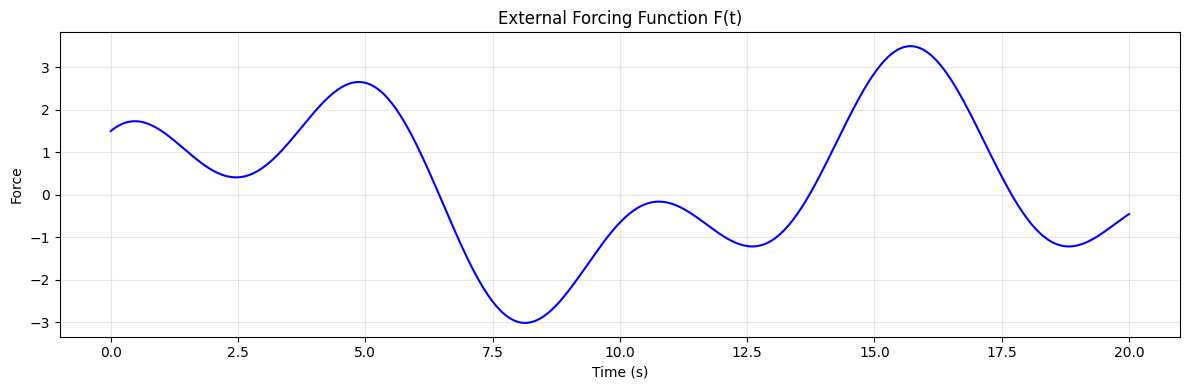

In [3]:
def generate_force(t: np.ndarray, mode: str = "standard") -> np.ndarray:
    """
    Generate a time-varying force (sum of sinusoids).
    
    Args:
        t: Time vector
        mode: "standard" for training, "extrapolation" for testing
        
    Returns:
        Force values over time
    """
    if mode == "standard":
        # Force used for training
        return 2.0 * np.sin(0.5 * t) + 1.5 * np.cos(1.2 * t)
    elif mode == "extrapolation":
        # Different force for testing extrapolation
        return 2.5 * np.sin(0.3 * t) + 2.0 * np.cos(0.8 * t) + 0.5 * np.sin(2.0 * t)
    else:
        raise ValueError(f"Unknown mode: {mode}")


# Visualize the force function
t_demo = np.linspace(0, 20, 500)
force_demo = generate_force(t_demo, "standard")

plt.figure(figsize=(12, 4))
plt.plot(t_demo, force_demo, 'b-', linewidth=1.5)
plt.title("External Forcing Function F(t)")
plt.xlabel("Time (s)")
plt.ylabel("Force")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 1.2 Implicit Euler Solver

We implement the **implicit Euler method** to solve the Duffing equation. Since the equation is nonlinear, we need to use **Newton-Raphson iteration** at each time step.

The Duffing system can be written as two first-order ODEs:

$$\dot{x} = v$$
$$\dot{v} = \frac{1}{m}(F(t) - cv - k_1 x - k_3 x^3)$$

The implicit Euler discretization gives:

$$x_{n+1} = x_n + \Delta t \cdot v_{n+1}$$
$$v_{n+1} = v_n + \frac{\Delta t}{m}(F_{n+1} - c \cdot v_{n+1} - k_1 x_{n+1} - k_3 x_{n+1}^3)$$

In [4]:
def implicit_euler_step(x_n: float, v_n: float, f_n1: float, dt: float) -> Tuple[float, float]:
    """
    Solve one time step using Implicit Euler + Newton-Raphson.
    
    The implicit Euler equations form a nonlinear system that we solve
    using scipy's fsolve (which uses Newton-Raphson under the hood).
    
    Args:
        x_n: Position at time n
        v_n: Velocity at time n
        f_n1: Force at time n+1
        dt: Time step
        
    Returns:
        Tuple (position, velocity) at time n+1
    """
    def equations(p):
        """System of equations to solve for (x_{n+1}, v_{n+1})"""
        x_new, v_new = p
        
        # Equation 1: x_{n+1} = x_n + dt * v_{n+1}
        res1 = x_new - x_n - dt * v_new
        
        # Equation 2: v_{n+1} = v_n + (dt/m) * (F - c*v - k1*x - k3*x^3)
        res2 = v_new - v_n - (dt / config.m) * (
            f_n1 - config.c * v_new - config.k1 * x_new - config.k3 * x_new**3
        )
        return [res1, res2]
    
    # Solve using Newton-Raphson (initial guess: current state)
    x_next, v_next = fsolve(equations, [x_n, v_n])
    return x_next, v_next

## 1.3 Full Simulation

In [5]:
def simulate_duffing(
    t_max: float, 
    dt: float, 
    force_mode: str = "standard"
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Simulate the Duffing oscillator for the specified duration.
    
    Args:
        t_max: Total simulation time
        dt: Time step
        force_mode: Mode for force generation
        
    Returns:
        Tuple (time, positions, velocities, forces)
    """
    n_steps = int(t_max / dt)
    t_eval = np.linspace(0, t_max, n_steps)
    
    # Initialize arrays
    x_sim = np.zeros(n_steps)
    v_sim = np.zeros(n_steps)
    forces = generate_force(t_eval, mode=force_mode)
    
    print(f"Simulating Duffing oscillator: {n_steps} time steps, t_max={t_max}s")
    
    # Time-stepping loop
    for i in range(n_steps - 1):
        x_sim[i + 1], v_sim[i + 1] = implicit_euler_step(
            x_sim[i], v_sim[i], forces[i + 1], dt
        )
    
    return t_eval, x_sim, v_sim, forces


# Run simulation
print("\n" + "=" * 60)
print("PART 1: DATASET GENERATION")
print("=" * 60)

t_eval, x_sim, v_sim, forces = simulate_duffing(config.t_max, config.dt, "standard")
print(f"Simulation complete!")


PART 1: DATASET GENERATION
Simulating Duffing oscillator: 2000 time steps, t_max=100.0s
Simulation complete!


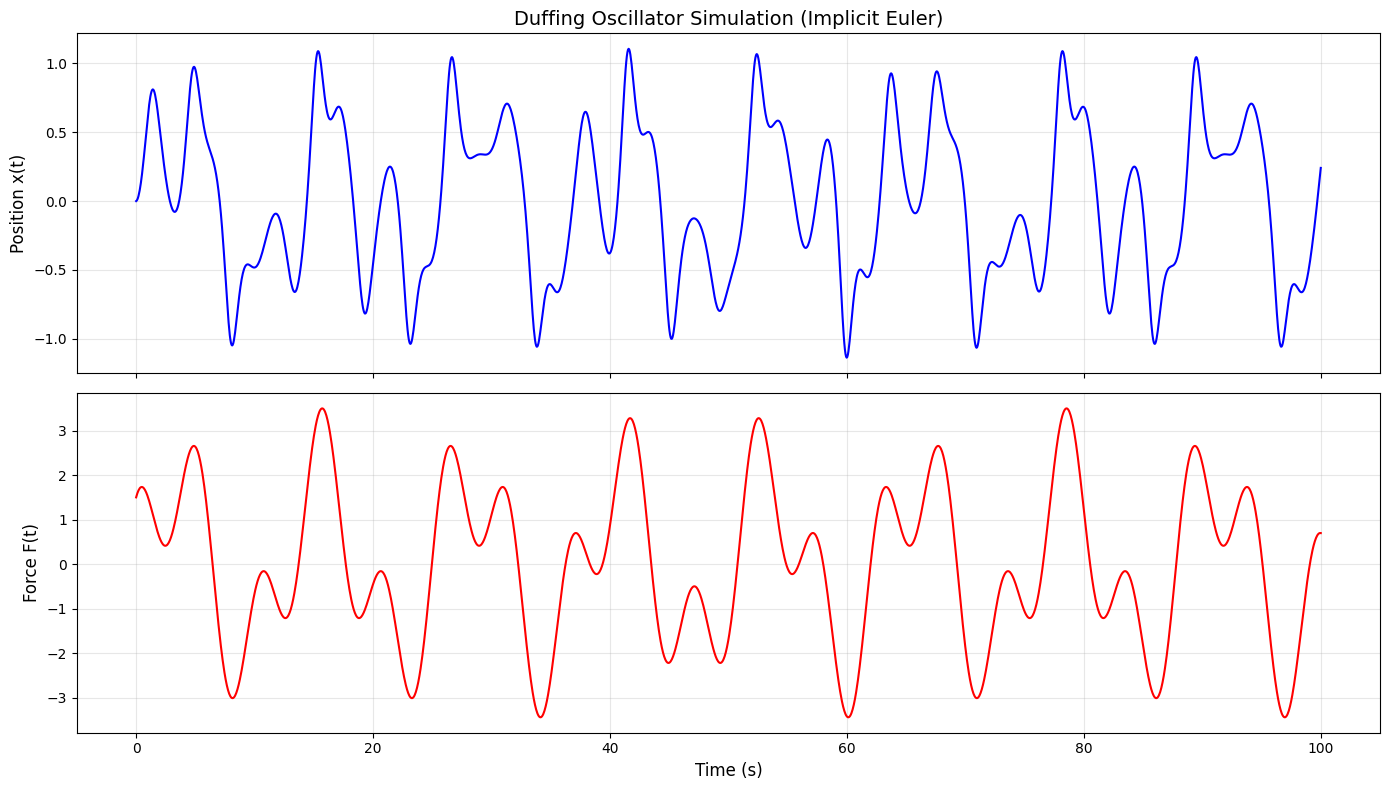

In [6]:
# Visualize the simulation results
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Position plot
axes[0].plot(t_eval, x_sim, 'b-', linewidth=1.5)
axes[0].set_ylabel('Position x(t)', fontsize=12)
axes[0].set_title('Duffing Oscillator Simulation (Implicit Euler)', fontsize=14)
axes[0].grid(True, alpha=0.3)

# Force plot
axes[1].plot(t_eval, forces, 'r-', linewidth=1.5)
axes[1].set_xlabel('Time (s)', fontsize=12)
axes[1].set_ylabel('Force F(t)', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 1.4 Create Sliding Window Sequences

To train the RNN, we create sequences using a **sliding window** approach:
- **Input (X)**: A window of past force values $[F_{t-W}, ..., F_{t-1}]$
- **Output (y)**: The position at the next time step $x_t$

This teaches the RNN to predict the system's response given a history of applied forces.

In [7]:
def create_sequences(data: np.ndarray, force: np.ndarray, window: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Create sequences for RNN training using sliding window.
    
    Args:
        data: Position data (what we want to predict)
        force: Force data (input features)
        window: Window size (sequence length)
        
    Returns:
        Tuple (X, y) for training
    """
    X, y = [], []
    for i in range(len(data) - window):
        # Input: window of force values
        X.append(force[i:i + window])
        # Output: position after the window
        y.append(data[i + window])
    return np.array(X), np.array(y)


# Create sequences
X, Y = create_sequences(x_sim, forces, config.window_size)
print(f"Sequences created: X.shape={X.shape}, Y.shape={Y.shape}")
print(f"Each input sequence contains {config.window_size} force values")

Sequences created: X.shape=(1980, 20), Y.shape=(1980,)
Each input sequence contains 20 force values


## 1.5 Create DataLoaders

We split the data into:
- **Training set (70%)**: Used to train the model
- **Validation set (15%)**: Used for early stopping
- **Test set (15%)**: Used for final evaluation

In [8]:
def generate_dataset() -> Tuple[DataLoader, DataLoader, DataLoader, dict]:
    """
    Generate the complete dataset with train/val/test splits.
    
    Returns:
        Tuple (train_loader, val_loader, test_loader, info_dict)
    """
    # Simulation
    t_eval, x_sim, v_sim, forces = simulate_duffing(config.t_max, config.dt, "standard")
    
    # Create sequences
    X, Y = create_sequences(x_sim, forces, config.window_size)
    print(f"Sequences created: X.shape={X.shape}, Y.shape={Y.shape}")
    
    # Convert to tensors
    # Shape: [n_samples, window_size, 1] for X
    # Shape: [n_samples, 1] for Y
    X_t = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)
    Y_t = torch.tensor(Y, dtype=torch.float32).unsqueeze(-1)
    
    # Split train/val/test
    n_samples = len(X_t)
    n_train = int(config.train_ratio * n_samples)
    n_val = int(config.val_ratio * n_samples)
    
    X_train, Y_train = X_t[:n_train], Y_t[:n_train]
    X_val, Y_val = X_t[n_train:n_train + n_val], Y_t[n_train:n_train + n_val]
    X_test, Y_test = X_t[n_train + n_val:], Y_t[n_train + n_val:]
    
    print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
    
    # Create DataLoaders
    train_dataset = TensorDataset(X_train, Y_train)
    val_dataset = TensorDataset(X_val, Y_val)
    test_dataset = TensorDataset(X_test, Y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)
    
    # Info for visualization later
    info = {
        't_eval': t_eval,
        'x_sim': x_sim,
        'forces': forces,
        'n_train': n_train,
        'n_val': n_val,
        'window_size': config.window_size
    }
    
    print("✓ Dataset generated successfully!")
    return train_loader, val_loader, test_loader, info


# Generate the dataset
train_loader, val_loader, test_loader, info = generate_dataset()

Simulating Duffing oscillator: 2000 time steps, t_max=100.0s
Sequences created: X.shape=(1980, 20), Y.shape=(1980,)
Train: 1386, Val: 297, Test: 297
✓ Dataset generated successfully!


---

# Part 2: RNN Model and Training

Now we define and train our Recurrent Neural Network.

## 2.1 RNN Architecture

We use a simple **Elman RNN** with:
- 2 stacked RNN layers with 64 hidden units each
- tanh activation function
- A final fully-connected layer to produce the scalar output

The network takes a sequence of force values and predicts the resulting position.

In [9]:
class DuffingRNN(nn.Module):
    """
    RNN for approximating the Duffing oscillator dynamics.
    Uses a simple Elman RNN architecture.
    """
    def __init__(
        self,
        input_size: int = 1,
        hidden_size: int = 64,
        num_layers: int = 2,
        dropout: float = 0.1
    ):
        super(DuffingRNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # RNN layers
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            nonlinearity='tanh'
        )
        
        # Output layer: maps hidden state to scalar output
        self.fc = nn.Linear(hidden_size, 1)
        
        # Initialize weights for stability
        self._init_weights()
    
    def _init_weights(self):
        """Orthogonal initialization for better gradient flow"""
        for name, param in self.rnn.named_parameters():
            if 'weight_ih' in name:  # Input-hidden weights
                nn.init.xavier_uniform_(param)
            elif 'weight_hh' in name:  # Hidden-hidden weights
                nn.init.orthogonal_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)
    
    def forward(self, x: torch.Tensor, h0: Optional[torch.Tensor] = None) -> torch.Tensor:
        """
        Forward pass.
        
        Args:
            x: Input tensor [batch_size, seq_len, input_size]
            h0: Initial hidden state (optional)
            
        Returns:
            Output tensor [batch_size, 1]
        """
        # Pass through RNN layers
        out, _ = self.rnn(x, h0)
        
        # Take only the last time step's output
        out = self.fc(out[:, -1, :])
        return out


# Create model and show summary
model = DuffingRNN(
    input_size=config.input_size,
    hidden_size=config.hidden_size,
    num_layers=config.num_layers,
    dropout=config.dropout
).to(device)

n_params = sum(p.numel() for p in model.parameters())
print(f"Model architecture: DuffingRNN")
print(f"Total parameters: {n_params:,}")
print(model)

Model architecture: DuffingRNN
Total parameters: 12,673
DuffingRNN(
  (rnn): RNN(1, 64, num_layers=2, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


## 2.2 Early Stopping

Early stopping prevents overfitting by stopping training when validation loss stops improving.

In [10]:
class EarlyStopping:
    """Early stopping to stop training when validation loss stops improving."""
    
    def __init__(self, patience: int = 50, min_delta: float = 1e-6, path: str = "best_model.pt"):
        """
        Args:
            patience: Number of epochs to wait without improvement
            min_delta: Minimum change to qualify as improvement
            path: Path to save the best model
        """
        self.patience = patience
        self.min_delta = min_delta
        self.path = path
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
    
    def __call__(self, val_loss: float, model: nn.Module):
        """Check if we should stop and save best model"""
        if val_loss < self.best_loss - self.min_delta:
            # Improvement found
            self.best_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), self.path)
        else:
            # No improvement
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
    
    def load_best(self, model: nn.Module):
        """Load the best model weights"""
        model.load_state_dict(torch.load(self.path))

## 2.3 Training Loop

Our training includes several best practices:
- **Early stopping**: Stop if validation loss doesn't improve
- **Learning rate scheduling**: Reduce LR when stuck on a plateau
- **Gradient clipping**: Prevent exploding gradients
- **Model checkpointing**: Save the best model

In [11]:
def train_model(
    train_loader: DataLoader,
    val_loader: DataLoader
) -> Tuple[nn.Module, dict]:
    """
    Train the RNN model with optimizations.
    
    Features:
    - Early stopping
    - Learning rate scheduling (ReduceLROnPlateau)
    - Gradient clipping
    - Best model saving
    
    Args:
        train_loader: Training DataLoader
        val_loader: Validation DataLoader
        
    Returns:
        Tuple (trained_model, training_history)
    """
    print("\n" + "=" * 60)
    print("PART 2: TRAINING THE RNN MODEL")
    print("=" * 60)
    
    # Initialize model
    model = DuffingRNN(
        input_size=config.input_size,
        hidden_size=config.hidden_size,
        num_layers=config.num_layers,
        dropout=config.dropout
    ).to(device)
    
    print(f"Device: {device}")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # Loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
    
    # Learning rate scheduler: reduce LR when validation loss plateaus
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=20
    )
    
    # Early stopping
    early_stopping = EarlyStopping(
        patience=config.patience,
        min_delta=config.min_delta,
        path=config.checkpoint_path
    )
    
    # Training history
    history = {'train_loss': [], 'val_loss': [], 'lr': []}
    
    print(f"\nStarting training: max {config.max_epochs} epochs, patience={config.patience}")
    print("-" * 60)
    
    for epoch in range(config.max_epochs):
        # ===== Training Phase =====
        model.train()
        train_loss = 0.0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), config.grad_clip)
            
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        
        # ===== Validation Phase =====
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        
        # Update learning rate scheduler
        scheduler.step(val_loss)
        
        # Record history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['lr'].append(optimizer.param_groups[0]['lr'])
        
        # Check early stopping
        early_stopping(val_loss, model)
        
        # Logging every 20 epochs or at early stopping
        if (epoch + 1) % 20 == 0 or early_stopping.early_stop:
            print(f"Epoch [{epoch + 1:4d}/{config.max_epochs}] "
                  f"Train Loss: {train_loss:.6f} | "
                  f"Val Loss: {val_loss:.6f} | "
                  f"LR: {optimizer.param_groups[0]['lr']:.2e}")
        
        if early_stopping.early_stop:
            print(f"\n⚠ Early stopping triggered at epoch {epoch + 1}")
            break
    
    # Load the best model
    early_stopping.load_best(model)
    print(f"\n✓ Best model loaded (val_loss: {early_stopping.best_loss:.6f})")
    
    return model, history


# Train the model
model, history = train_model(train_loader, val_loader)


PART 2: TRAINING THE RNN MODEL
Device: cuda
Model parameters: 12,673

Starting training: max 1000 epochs, patience=50
------------------------------------------------------------
Epoch [  20/1000] Train Loss: 0.017183 | Val Loss: 0.015661 | LR: 1.00e-03
Epoch [  40/1000] Train Loss: 0.012868 | Val Loss: 0.011525 | LR: 1.00e-03
Epoch [  60/1000] Train Loss: 0.013956 | Val Loss: 0.012535 | LR: 1.00e-03
Epoch [  80/1000] Train Loss: 0.009077 | Val Loss: 0.008067 | LR: 5.00e-04
Epoch [ 100/1000] Train Loss: 0.008337 | Val Loss: 0.009532 | LR: 5.00e-04
Epoch [ 120/1000] Train Loss: 0.009153 | Val Loss: 0.007483 | LR: 5.00e-04
Epoch [ 140/1000] Train Loss: 0.007219 | Val Loss: 0.005925 | LR: 2.50e-04
Epoch [ 160/1000] Train Loss: 0.007123 | Val Loss: 0.005870 | LR: 2.50e-04
Epoch [ 180/1000] Train Loss: 0.006255 | Val Loss: 0.005442 | LR: 1.25e-04
Epoch [ 200/1000] Train Loss: 0.006211 | Val Loss: 0.005022 | LR: 1.25e-04
Epoch [ 220/1000] Train Loss: 0.005955 | Val Loss: 0.004972 | LR: 6.25

## 2.4 Visualize Training History

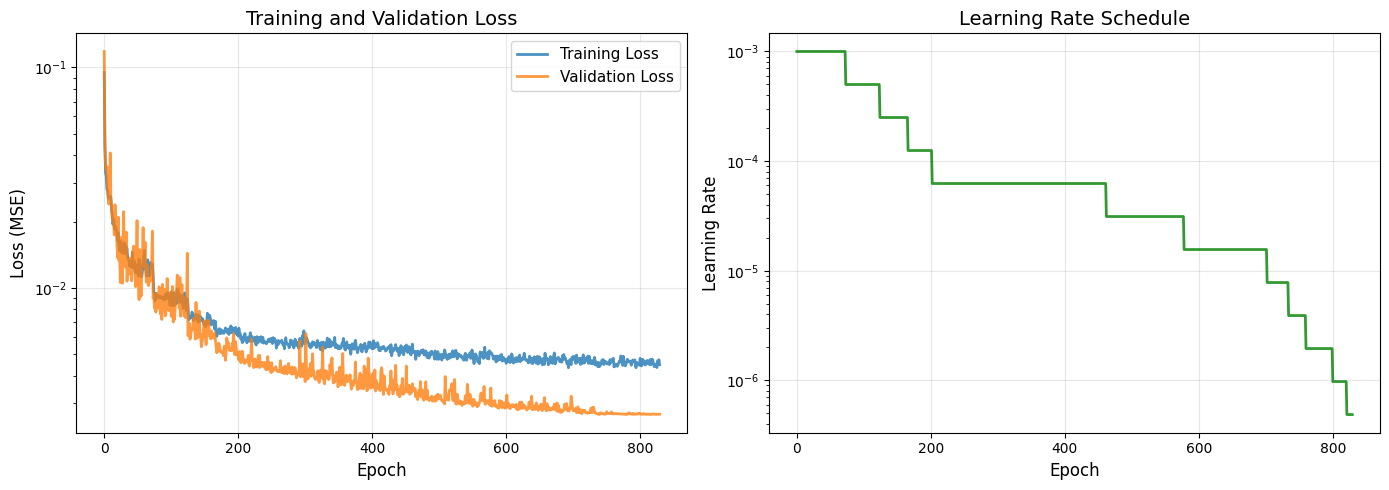

✓ Training history saved: training_history.png


In [12]:
def plot_training_history(history: dict):
    """Display training history plots."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Loss curves
    ax1 = axes[0]
    ax1.plot(history['train_loss'], label='Training Loss', alpha=0.8, linewidth=2)
    ax1.plot(history['val_loss'], label='Validation Loss', alpha=0.8, linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss (MSE)', fontsize=12)
    ax1.set_title('Training and Validation Loss', fontsize=14)
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.set_yscale('log')
    
    # Learning rate
    ax2 = axes[1]
    ax2.plot(history['lr'], 'g-', alpha=0.8, linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Learning Rate', fontsize=12)
    ax2.set_title('Learning Rate Schedule', fontsize=14)
    ax2.grid(True, alpha=0.3)
    ax2.set_yscale('log')
    
    plt.tight_layout()
    plt.savefig("training_history.png", dpi=150)
    plt.show()
    
    print("✓ Training history saved: training_history.png")


plot_training_history(history)

---

# Part 3: Model Evaluation

Let's evaluate our trained model on the test set.


PART 3: MODEL EVALUATION

Test Set Metrics:
  MSE:  0.004078
  MAE:  0.044529
  RMSE: 0.063863
  R²:   0.988230


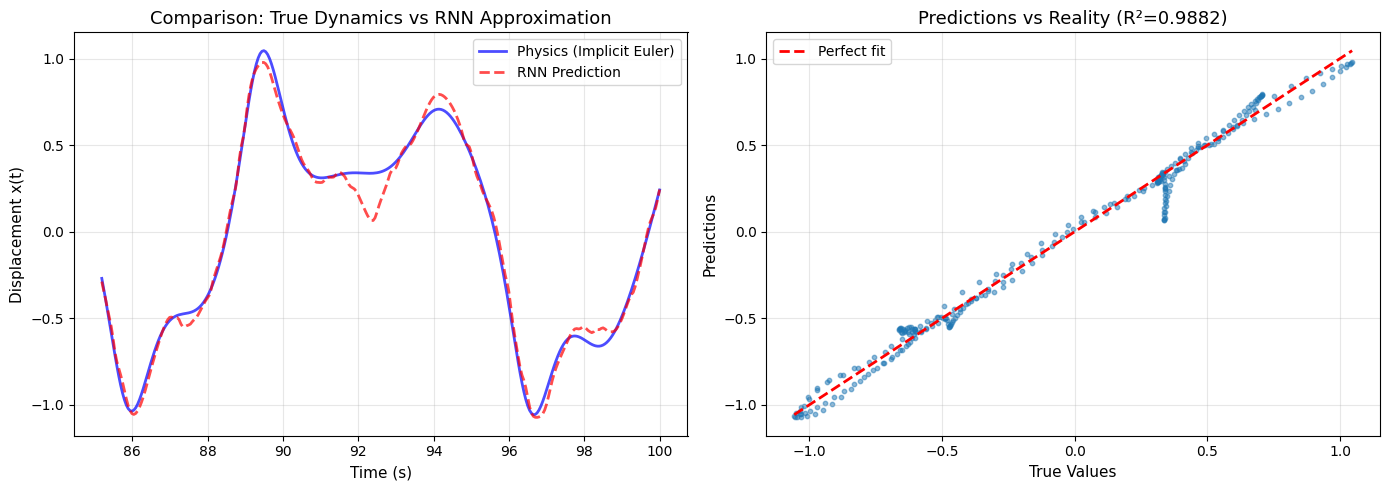


✓ Evaluation plots saved: evaluation_results.png


In [13]:
def evaluate_model(
    model: nn.Module,
    test_loader: DataLoader,
    info: dict
) -> dict:
    """
    Evaluate the model on the test set.
    
    Args:
        model: Trained model
        test_loader: Test DataLoader
        info: Dataset info dictionary
        
    Returns:
        Dictionary of metrics
    """
    print("\n" + "=" * 60)
    print("PART 3: MODEL EVALUATION")
    print("=" * 60)
    
    model.eval()
    
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            all_preds.append(outputs.cpu().numpy())
            all_targets.append(y_batch.numpy())
    
    predictions = np.concatenate(all_preds, axis=0).flatten()
    targets = np.concatenate(all_targets, axis=0).flatten()
    
    # Calculate metrics
    mse = np.mean((predictions - targets) ** 2)
    mae = np.mean(np.abs(predictions - targets))
    rmse = np.sqrt(mse)
    
    # R² score (coefficient of determination)
    ss_res = np.sum((targets - predictions) ** 2)
    ss_tot = np.sum((targets - np.mean(targets)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    
    metrics = {'MSE': mse, 'MAE': mae, 'RMSE': rmse, 'R2': r2}
    
    print("\nTest Set Metrics:")
    print(f"  MSE:  {mse:.6f}")
    print(f"  MAE:  {mae:.6f}")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  R²:   {r2:.6f}")
    
    # Create visualizations
    test_start = info['n_train'] + info['n_val'] + info['window_size']
    t_test = info['t_eval'][test_start:test_start + len(predictions)]
    x_true = info['x_sim'][test_start:test_start + len(predictions)]
    
    plt.figure(figsize=(14, 5))
    
    # Time series comparison
    plt.subplot(1, 2, 1)
    plt.plot(t_test, x_true, 'b-', label='Physics (Implicit Euler)', alpha=0.7, linewidth=2)
    plt.plot(t_test, predictions, 'r--', label='RNN Prediction', alpha=0.7, linewidth=2)
    plt.title("Comparison: True Dynamics vs RNN Approximation", fontsize=13)
    plt.xlabel("Time (s)", fontsize=11)
    plt.ylabel("Displacement x(t)", fontsize=11)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # Scatter plot: predictions vs actual
    plt.subplot(1, 2, 2)
    plt.scatter(x_true, predictions, alpha=0.5, s=10)
    plt.plot([x_true.min(), x_true.max()], [x_true.min(), x_true.max()], 'r--', linewidth=2, label='Perfect fit')
    plt.title(f"Predictions vs Reality (R²={r2:.4f})", fontsize=13)
    plt.xlabel("True Values", fontsize=11)
    plt.ylabel("Predictions", fontsize=11)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig("evaluation_results.png", dpi=150)
    plt.show()
    
    print("\n✓ Evaluation plots saved: evaluation_results.png")
    
    return metrics


# Evaluate the model
metrics = evaluate_model(model, test_loader, info)

---

# Part 4: Extrapolation Test

One of the key questions for any learned model is: **how well does it generalize beyond the training data?**

We test this by simulating beyond the original training time horizon and comparing the RNN predictions to the physics-based simulation.


PART 4: INFERENCE AND EXTRAPOLATION TEST

--- Extended Temporal Simulation (same force) ---
Simulating Duffing oscillator: 4000 time steps, t_max=200.0s
MSE on 'seen' data (0-100s):       0.003628
MSE on extrapolation (100-200s):   0.003443
Degradation ratio: 0.95x


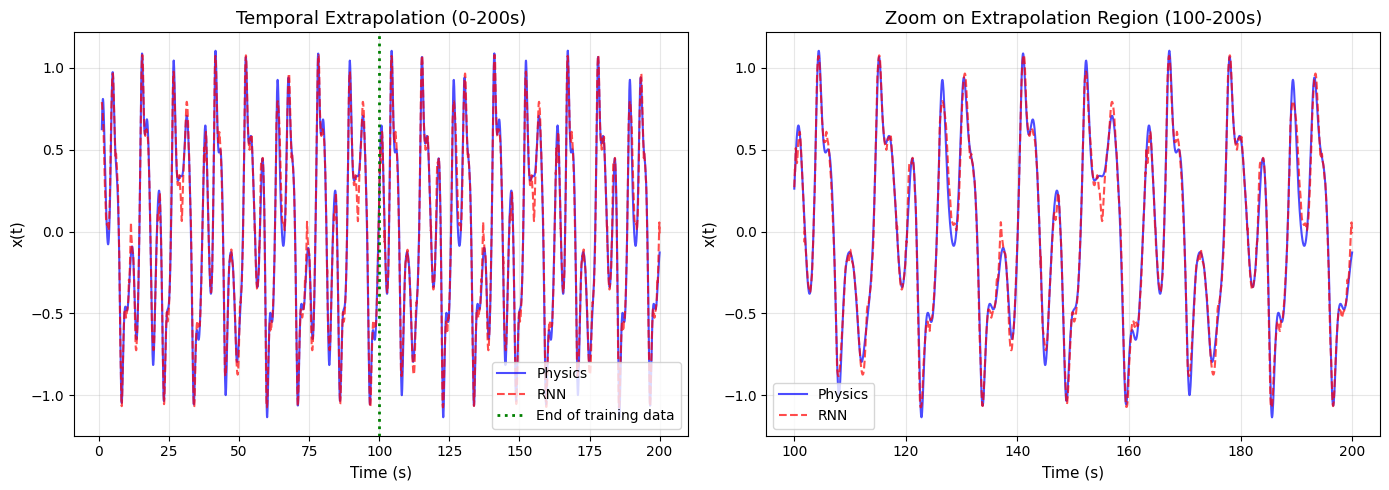


✓ Extrapolation plots saved: extrapolation_results.png


In [14]:
def test_extrapolation(model: nn.Module) -> dict:
    """
    Test the model's extrapolation capability on a longer simulation.
    
    Args:
        model: Trained model
        
    Returns:
        Dictionary of extrapolation results
    """
    print("\n" + "=" * 60)
    print("PART 4: INFERENCE AND EXTRAPOLATION TEST")
    print("=" * 60)
    
    model.eval()
    
    # Extended simulation with the same force
    print("\n--- Extended Temporal Simulation (same force) ---")
    t_long, x_long, _, forces_long = simulate_duffing(
        config.t_max_extrapolation, config.dt, "standard"
    )
    
    X_long, Y_long = create_sequences(x_long, forces_long, config.window_size)
    X_long_t = torch.tensor(X_long, dtype=torch.float32).unsqueeze(-1).to(device)
    
    with torch.no_grad():
        preds_long = model(X_long_t).cpu().numpy().flatten()
    
    # Compute metrics for "seen" (0-100s) vs "extrapolated" (100-200s) regions
    n_train_equiv = int(config.t_max / config.dt) - config.window_size
    
    mse_seen = np.mean((preds_long[:n_train_equiv] - Y_long[:n_train_equiv]) ** 2)
    mse_extrapolated = np.mean((preds_long[n_train_equiv:] - Y_long[n_train_equiv:]) ** 2)
    
    print(f"MSE on 'seen' data (0-100s):       {mse_seen:.6f}")
    print(f"MSE on extrapolation (100-200s):   {mse_extrapolated:.6f}")
    print(f"Degradation ratio: {mse_extrapolated / mse_seen:.2f}x")
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Full time series
    ax1 = axes[0]
    t_plot = t_long[config.window_size:]
    ax1.plot(t_plot, Y_long, 'b-', label='Physics', alpha=0.7, linewidth=1.5)
    ax1.plot(t_plot, preds_long, 'r--', label='RNN', alpha=0.7, linewidth=1.5)
    ax1.axvline(x=config.t_max, color='g', linestyle=':', linewidth=2, label='End of training data')
    ax1.set_title("Temporal Extrapolation (0-200s)", fontsize=13)
    ax1.set_xlabel("Time (s)", fontsize=11)
    ax1.set_ylabel("x(t)", fontsize=11)
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Zoom on extrapolation region
    ax2 = axes[1]
    mask = t_plot > config.t_max
    ax2.plot(t_plot[mask], Y_long[mask], 'b-', label='Physics', alpha=0.7, linewidth=1.5)
    ax2.plot(t_plot[mask], preds_long[mask], 'r--', label='RNN', alpha=0.7, linewidth=1.5)
    ax2.set_title("Zoom on Extrapolation Region (100-200s)", fontsize=13)
    ax2.set_xlabel("Time (s)", fontsize=11)
    ax2.set_ylabel("x(t)", fontsize=11)
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig("extrapolation_results.png", dpi=150)
    plt.show()
    
    print("\n✓ Extrapolation plots saved: extrapolation_results.png")
    
    results = {
        'mse_seen': mse_seen,
        'mse_extrapolated': mse_extrapolated,
        'degradation_ratio': mse_extrapolated / mse_seen
    }
    
    return results


# Test extrapolation
extrapolation_results = test_extrapolation(model)

---

# Summary

Let's summarize our results.

In [15]:
print("\n" + "=" * 60)
print("                    FINAL SUMMARY")
print("=" * 60)

print("\n📊 Test Set Metrics:")
print(f"   • MSE:  {metrics['MSE']:.6f}")
print(f"   • RMSE: {metrics['RMSE']:.6f}")
print(f"   • MAE:  {metrics['MAE']:.6f}")
print(f"   • R²:   {metrics['R2']:.6f}")

print("\n🔮 Extrapolation Capability:")
print(f"   • MSE on seen data (0-100s):     {extrapolation_results['mse_seen']:.6f}")
print(f"   • MSE on extrapolation (100-200s): {extrapolation_results['mse_extrapolated']:.6f}")
print(f"   • Degradation ratio: {extrapolation_results['degradation_ratio']:.2f}x")

print("\n✅ Pipeline complete!")


                    FINAL SUMMARY

📊 Test Set Metrics:
   • MSE:  0.004078
   • RMSE: 0.063863
   • MAE:  0.044529
   • R²:   0.988230

🔮 Extrapolation Capability:
   • MSE on seen data (0-100s):     0.003628
   • MSE on extrapolation (100-200s): 0.003443
   • Degradation ratio: 0.95x

✅ Pipeline complete!
